<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/1e_mnist_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de MNIST con un red densa

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes de dígitos implementando una red densa multicapa en PyTorch.

Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Está compuesto de imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600"/>
Conjunto MNIST. Imagen tomada de Wikipedia.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [3]:
# parche para bicho en colab
# https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### 1.2 Auxiliares

In [4]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_pipeline.png"/>
&nbsp;
Tuberia de datos para MNIST.

### 2.2 Exploración

PyTorch provee la clase [`MNIST`](https://pytorch.org/vision/0.8/datasets.html#mnist), una implementación de `Dataset` lista para usar del conjunto MNIST.

In [5]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


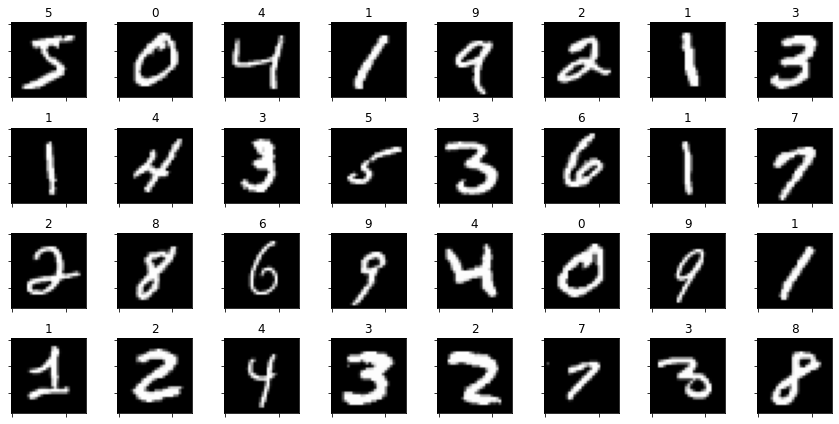

In [6]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

### 2.3 Cargadores de datos

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/eval_trn_tst.svg" width="450"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


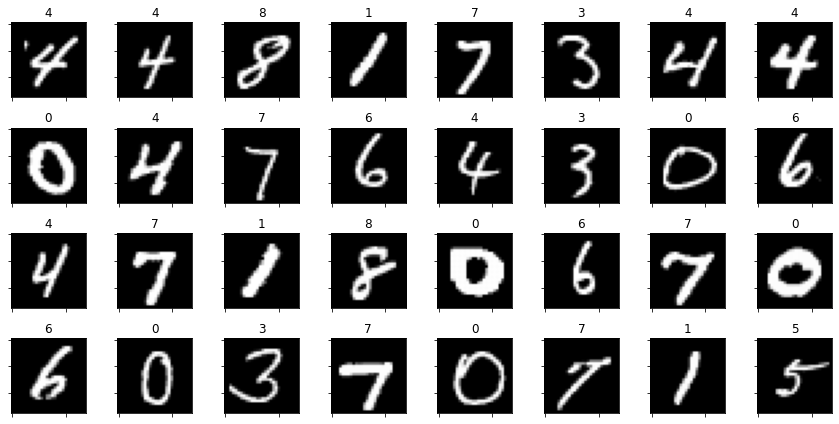

In [7]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


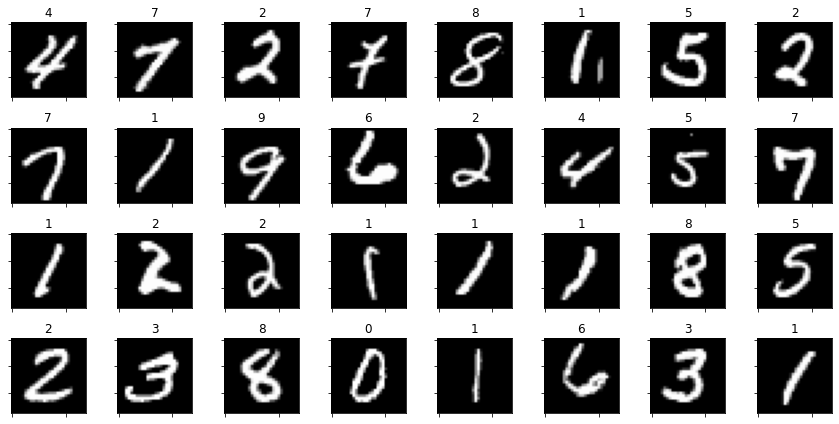

In [8]:
# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/fcn_arch.png"/>
&nbsp;
Arquitectura de la red completamente conectada.

### 3.1 Definición de la arquitectura

In [9]:
# definición del modelo
class FCN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 1x28x28] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 28, 28] => [M, 1x28x28]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x28x28]
        x = self.cls(x)
        
        return x

### 3.2 Instancia de la arquitectura

In [10]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [12]:
summary(model, (1, 28, 28), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 128]                  100,480
|    └─Sigmoid: 2-2                      [1, 128]                  --
|    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [13]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos un modelo:

In [14]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:11<03:47, 11.99s/it]

E00 loss=[225.36,225.23] acc=[29.49,29.65]


 10%|█         | 2/20 [00:23<03:29, 11.66s/it]

E01 loss=[220.16,219.93] acc=[40.67,42.45]


 15%|█▌        | 3/20 [00:34<03:15, 11.48s/it]

E02 loss=[213.75,213.39] acc=[51.45,53.38]


 20%|██        | 4/20 [00:45<03:02, 11.41s/it]

E03 loss=[205.73,205.21] acc=[56.68,57.52]


 25%|██▌       | 5/20 [00:58<02:57, 11.83s/it]

E04 loss=[195.88,195.15] acc=[61.52,62.58]


 30%|███       | 6/20 [01:10<02:46, 11.87s/it]

E05 loss=[184.39,183.48] acc=[63.38,63.96]


 35%|███▌      | 7/20 [01:22<02:33, 11.83s/it]

E06 loss=[171.82,170.70] acc=[65.99,66.84]


 40%|████      | 8/20 [01:34<02:21, 11.80s/it]

E07 loss=[158.94,157.62] acc=[68.19,69.10]


 45%|████▌     | 9/20 [01:46<02:11, 11.95s/it]

E08 loss=[146.51,144.99] acc=[72.56,73.51]


 50%|█████     | 10/20 [01:58<02:01, 12.11s/it]

E09 loss=[135.06,133.47] acc=[74.41,75.22]


 55%|█████▌    | 11/20 [02:10<01:48, 12.00s/it]

E10 loss=[124.82,123.18] acc=[75.30,76.18]


 60%|██████    | 12/20 [02:22<01:34, 11.85s/it]

E11 loss=[115.85,114.10] acc=[77.07,77.83]


 65%|██████▌   | 13/20 [02:34<01:23, 11.96s/it]

E12 loss=[108.06,106.26] acc=[78.67,79.54]


 70%|███████   | 14/20 [02:46<01:12, 12.10s/it]

E13 loss=[101.27, 99.46] acc=[79.57,80.27]


 75%|███████▌  | 15/20 [02:59<01:01, 12.30s/it]

E14 loss=[ 95.36, 93.55] acc=[80.49,81.09]


 80%|████████  | 16/20 [03:11<00:48, 12.12s/it]

E15 loss=[ 90.21, 88.39] acc=[81.02,81.77]


 85%|████████▌ | 17/20 [03:23<00:36, 12.31s/it]

E16 loss=[ 85.67, 83.84] acc=[82.09,82.60]


 90%|█████████ | 18/20 [03:35<00:24, 12.25s/it]

E17 loss=[ 81.67, 79.81] acc=[82.56,83.22]


 95%|█████████▌| 19/20 [03:47<00:12, 12.01s/it]

E18 loss=[ 78.13, 76.29] acc=[83.09,83.71]


100%|██████████| 20/20 [03:59<00:00, 11.96s/it]

E19 loss=[ 74.96, 73.15] acc=[83.44,84.08]


### 4.2 Gráficas de pérdidas y exactitud

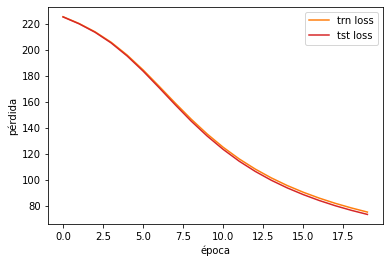

In [15]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

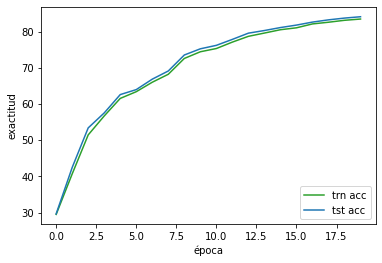

In [16]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/eval_trn_tst.svg" width="450"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [17]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 74.96, 73.10] acc=[83.44,84.12]


### 5.2 Inferencia

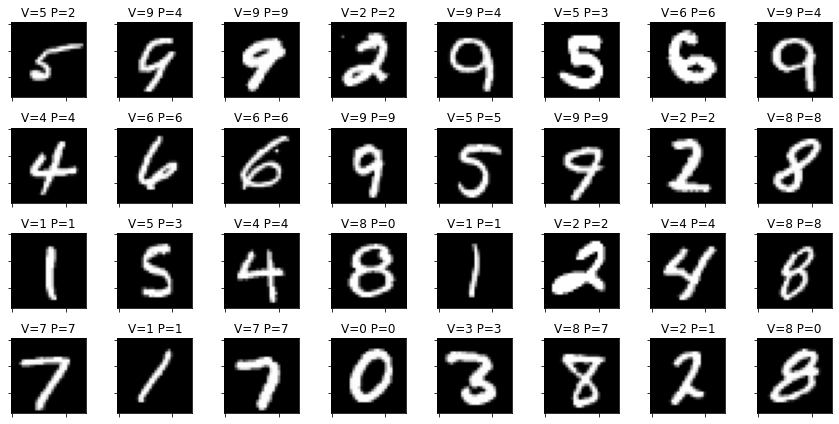

In [18]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## Participación

Remplaza la función de activación de la capa oculta por una [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), vuelve a entrenar y compara tus resultados.